# Segmentation Inference Example

This notebooks aims to demo the inference on a custom data sample, instead of using pre-defined tfds dataset.

To execute this notebook, please follow the [README](https://github.com/mathpluscode/ImgX-DiffSeg) to install the `imgx` package locally. The muscle ultrasound data set also needs to be built using `tfds build imgx/datasets/muscle_us`.

In [1]:
from pathlib import Path
import numpy as np
import jax
from flax.training import common_utils
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from imgx.task.segmentation.experiment import SegmentationExperiment
from imgx.datasets.constant import IMAGE, LABEL, LABEL_PRED
from imgx.datasets.save import load_2d_grayscale_image

/Users/yunguanfu/miniforge3/envs/imgx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load a model

The model is a supervisedly trained four-layer U-net with channels [8, 16, 32, 64].

In [2]:
config_path = "config.yaml" # backup config stored
ckpt_dir = "files/ckpt"
step = 1900

In [3]:
config = OmegaConf.load(config_path)
run = SegmentationExperiment(config=config)

## Evaluate on a custom image

`BB_anon_348_1` is a training data from `muscle_us` data set.

In [4]:
seed = 0
out_dir = Path("outputs")

image = load_2d_grayscale_image("BB_anon_348_1.png", dtype=np.float32)
label = load_2d_grayscale_image("BB_anon_348_1_mask.png")
# image.shape =  (1, 1, 480, 512, 1) label.shape = (1, 1, 480, 512)
# the first axis is shard axis for pmap, the second axis is batch axis
batch = {IMAGE:image[None, None,..., None], LABEL:label[None, None, ...]}
uids = ["BB_anon_348_1"]

In [5]:
device_cpu = jax.devices("cpu")[0]
key = jax.random.PRNGKey(seed)
key = common_utils.shard_prng_key(key)

train_state, _ = run.train_init(batch=batch, ckpt_dir=ckpt_dir, step=step) # still loads data from tfds
uids, metrics, preds = run.eval_batch(
                train_state=train_state,
                key=key,
                batch=batch,
                uids=uids,
                device_cpu=device_cpu,
            )
label_pred = preds[LABEL_PRED]

## Visualize output

In [6]:
# get scalar values
print(jax.tree_map(lambda x: x.item(), metrics))

{'binary_dice_score_class_0': 0.9713174104690552, 'binary_dice_score_class_1': 0.8994527459144592, 'centroid_dist_class_0': 3.0381574630737305, 'centroid_dist_class_1': 12.569477081298828, 'class_0_proportion_label': 0.7809703946113586, 'class_0_proportion_pred': 0.7751233577728271, 'class_0_volume_label': 191.9320068359375, 'class_0_volume_pred': 190.49501037597656, 'class_1_proportion_label': 0.21902620792388916, 'class_1_proportion_pred': 0.22487325966358185, 'class_1_volume_label': 53.8280029296875, 'class_1_volume_pred': 55.2650032043457, 'hausdorff_dist_class_0': 27.434404589355008, 'hausdorff_dist_class_1': 36.00693109995926, 'iou_class_0': 0.944234311580658, 'iou_class_1': 0.817277729511261, 'mean_binary_dice_score': 0.9353851079940796, 'mean_binary_dice_score_without_background': 0.8994527459144592, 'mean_centroid_dist': 7.803817272186279, 'mean_centroid_dist_without_background': 12.569477081298828, 'mean_hausdorff_dist': 31.720667844657136, 'mean_hausdorff_dist_without_backgr

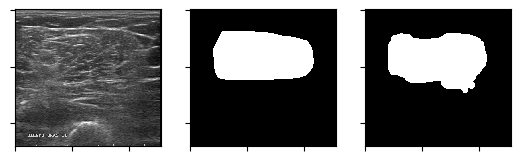

In [7]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image, cmap='gray',  interpolation='nearest')
axs[1].imshow(label, cmap='gray',  interpolation='nearest')
axs[2].imshow(label_pred[0], cmap='gray',  interpolation='nearest')
for i in range(3):
    axs[i].xaxis.set_tick_params(labelbottom=False)
    axs[i].yaxis.set_tick_params(labelleft=False)